In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline
import skopi as sk
import numpy as np
import os, time
import scipy.ndimage
import skopi.gpu as pg
from skopi.aggregate import build_bpca
from skopi.particlePlacement import *
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
import matplotlib.patches as patches
from matplotlib import cm

In [2]:
args = dict()
args['pdb_file'] = "/sdf/home/a/apeck/skopi/examples/input/pdb/3iyf.pdb"
args['beam_file'] = "/sdf/home/a/apeck/skopi/examples/input/beam/amo86615.beam"
args['geom_file'] = "/sdf/home/a/apeck/skopi/examples/input/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data"
args['increase_factor'] = 5e2

In [3]:
# generate beam
beam = sk.Beam(args['beam_file'])
beam.set_focus(5e-7,5e-7,'circle')
beam.set_photons_per_pulse(args['increase_factor']*beam.get_photons_per_pulse())

# generate detector
det = sk.PnccdDetector(geom=args['geom_file'], beam=beam)
det.distance = 0.2

# generate particle
particle = sk.Particle()
particle.read_pdb(args['pdb_file'], ff='WK')

In [4]:
imgs, positions, quats = dict(), dict(), dict()

# FXS of two of the same particles
jet_radius = 1e-7
exp = sk.FXSExperiment(det, beam, jet_radius, [particle], n_part_per_shot=2)
imgs['FXS'], positions['FXS'], quats['FXS'] = exp.generate_image_stack(return_photons=True, return_orientations=True, return_positions=True)

In [5]:
# SPI of individual particle
exp = sk.SPIExperiment(det, beam, particle)
exp.set_orientations(np.array([quats['FXS'][0]]))
exp.set_positions(np.array([positions['FXS'][0]]))
imgs['SPI'], positions['SPI'], quats['SPI'] = exp.generate_image_stack(return_photons=True, return_orientations=True, return_positions=True)

In [6]:
# SPI of aggregate
exp = sk.SPIExperiment(det, beam, particle, n_part_per_shot=2)
#exp.set_orientations(quats['FXS'])
imgs['SPI_agg'], positions['SPI_agg'], quats['SPI_agg'] = exp.generate_image_stack(return_photons=True, return_orientations=True, return_positions=True)

Generating particle 2 of 2
Generating particle 2 of 2


In [7]:
# create reference gold nanoparticle
xyz = np.loadtxt("/sdf/home/a/apeck/exafel/skopi_figs/Au309_input.xyz")[::2] #* 0.8*np.ones(3)
rparticle = sk.Particle()
rparticle.create_from_atoms([("AU", xyz[i]) for i in range(xyz.shape[0])])

exp = sk.HOLOExperiment(det, beam, [rparticle], [particle], jet_radius=1e-7, ref_jet_radius=1e-7,
                        ref_position=np.array([positions['FXS'][1]]), ref_orientation=np.array([quats['FXS'][1]]),
                        part_positions=np.array([positions['FXS'][0]]), part_orientations=np.array([quats['FXS'][0]]))
imgs['holo'], positions['holo'], quats['holo'] = exp.generate_image_stack(return_photons=True, return_orientations=True, return_positions=True)

In [8]:
# create mask -- for where gap is in detector
mask = np.ones_like(imgs['holo'])
mask = det.assemble_image_stack(mask)
mask = np.ma.masked_where(mask==1, mask)

/opt/anaconda/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0, 0.5, 'Pixels')

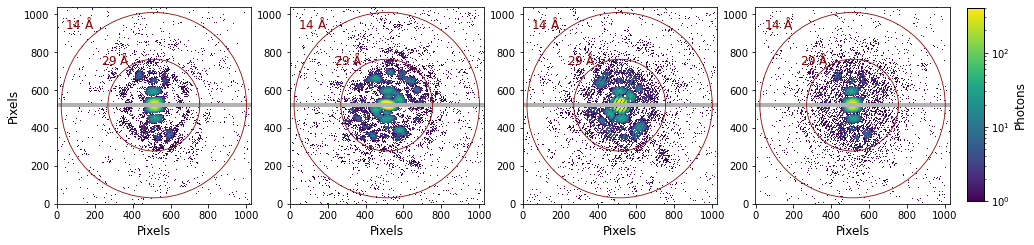

In [9]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(16,4))

s_mags = det.pixel_distance_reciprocal
norm = matplotlib.colors.LogNorm(vmin=1, vmax=imgs['SPI'].max())

for ax,key in zip([ax1,ax2,ax3,ax4],['SPI','SPI_agg','FXS','holo']):
    im = ax.imshow(det.assemble_image_stack(imgs[key]).T, norm=norm, origin='lower', interpolation='None')
    ax.imshow(mask.T, cmap=cm.gray, alpha=0.3, interpolation='None', origin='lower')
    ax.set_xlabel("Pixels", fontsize=12)
    
    # add diffraction rings
    center = 0.5*np.array(mask.T.shape)[::-1]
    s_start = s_mags.max() * 0.68
    steps = range(1,3)
    for i in steps:
        q = i*s_start/steps[-1]
        s = q/(2*beam.wavenumber)
        pix_rad = det.distance * 2 * s * np.sqrt(1-s**2) / (1-2*s**2) / np.mean(det.pixel_width)
        resolution = 1e10/q
        label_pos = 0.85*(1-0.03*i)

        ax.add_patch(Circle(center, pix_rad, edgecolor='darkred', fill=False, linewidth=0.8))
        ax.annotate("%i $\mathrm{\AA}$"%resolution, xy=(-label_pos*pix_rad+center[0], label_pos*pix_rad+center[1]),
                               ha="center", va="bottom", color="darkred", fontsize=12)
        
    cbar_ax = f.add_axes([0.915, 0.17, 0.015, 0.67])
    cb = f.colorbar(im, cax=cbar_ax)
    cb.set_label("Photons", fontsize=12)
    
    
ax1.set_ylabel("Pixels", fontsize=12)


Text(0.5, 1.0, 'Holography')

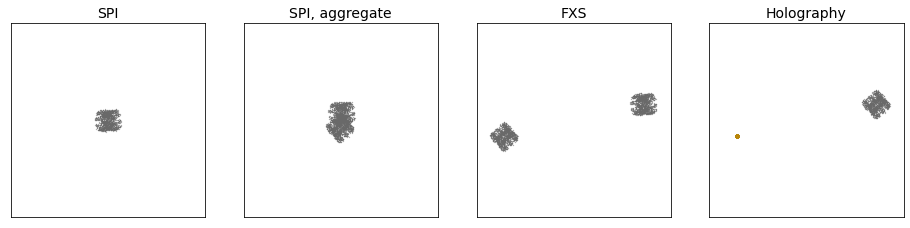

In [36]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(16,4))

for i,(ax,key) in enumerate(zip([ax1,ax2,ax3,ax4],['SPI','SPI_agg','FXS','holo'])):
    
    for p in range(positions[key].shape[0]):
        if key == 'holo' and p==0:
            particle.create_from_atoms([("AU", xyz[i]) for i in range(xyz.shape[0])])
            particle.rotate(quats['FXS'][p])
            c,s='darkgoldenrod',5
        else:
            # reload particle
            particle = sk.Particle()
            particle.read_pdb(args['pdb_file'], ff='WK')
            particle.rotate(quats['FXS'][p])
            c,s='dimgrey',0.05

        xyz = positions[key][p] + particle.atom_pos - np.mean(positions[key], axis=0)
        ax.scatter(xyz[::40,0], xyz[::40,1], s=s, c=c)        
    
    ax.set_xlim(-0.7e-7, 0.7e-7)
    ax.set_ylim(-0.7e-7, 0.7e-7)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_aspect(1.0)
    
ax1.set_title('SPI', fontsize=14)
ax2.set_title('SPI, aggregate', fontsize=14)
ax3.set_title('FXS', fontsize=14)
ax4.set_title('Holography', fontsize=14)


In [ ]:
# for 3d plot
f = plt.figure(figsize=plt.figaspect(0.25))

for i,(key,title) in enumerate(zip(['SPI','SPI_agg','FXS','holo'],['SPI', 'SPI, aggregate', 'FXS', 'Holography'])):
    ax = f.add_subplot(1,4,i+1,projection='3d')
    
    for p in range(positions[key].shape[0]):
        if key == 'holo' and p==0:
            particle.create_from_atoms([("AU", xyz[i]) for i in range(xyz.shape[0])])
            particle.rotate(quats['FXS'][p])
            c='goldenrod'
        else:
            # reload particle
            particle = sk.Particle()
            particle.read_pdb(args['pdb_file'], ff='WK')
            particle.rotate(quats['FXS'][p])
            c='dimgrey'

        xyz = positions[key][p] + particle.atom_pos - np.mean(positions[key], axis=0)
        ax.scatter(xyz[::40,0], xyz[::40,1], xyz[::40,2], s=0.05, c=c)
        
    ax.view_init(90,45)
    ax.axis('off')
    
    ax.set_xlim(-0.7e-7, 0.7e-7)
    ax.set_ylim(-0.7e-7, 0.7e-7)
    ax.set_zlim(-0.7e-7, 0.7e-7)
    ax.set_title(title)
    
f.subplots_adjust(wspace=0.005)
